# Creating a Color Magnitude Diagram from Ananke 

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex

In [26]:
%matplotlib inline

## Access Data

In [27]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.sim.h5")
print(f"\nOpening data from: {ananke_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print("File does not exist.")


Opening data from: /home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.sim.h5


In [28]:
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'dec', 'dmod', 'feh', 'glat', 'glon', 'grav', 'lsst_gmag', 'lsst_imag', 'lsst_rmag', 'lsst_umag', 'lsst_ymag', 'lsst_zmag', 'lum', 'mact', 'mtip', 'parentid', 'partid', 'px', 'py', 'pz', 'ra', 'rad', 'smass', 'teff', 'vx', 'vy', 'vz']


## Create HR Diagram

The following code was adapted from: https://github.com/athob/anankethon/blob/main/usage_example.ipynb.

In [29]:
hex_cmap = 'cividis'
hex_cmap = plt.get_cmap(hex_cmap)

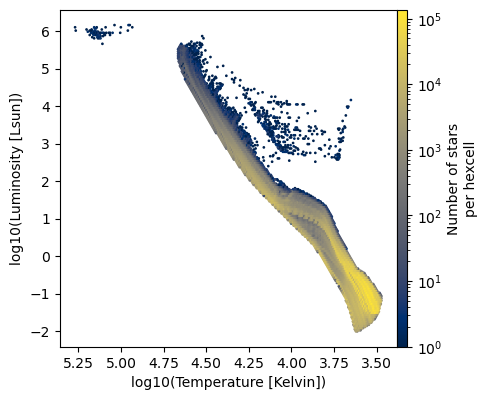

In [30]:
luminosity = survey.lum.to_numpy()
temperature = survey.teff.to_numpy()

fig3,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,8), subplot_kw={'adjustable':'box'})
fig3.subplots_adjust(wspace=0.8)
for ax in axs[1:]: ax.set_visible(False)

hb = axs[0].hexbin(temperature, luminosity, gridsize=(241),
                   bins='log', cmap=hex_cmap)

axs[0].invert_xaxis()
axs[0].set_xlabel('log10(Temperature [Kelvin])')
axs[0].set_ylabel('log10(Luminosity [Lsun])')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

ax0color_axis = axs[0].inset_axes([1, 0., 0.03, 1.], transform=axs[0].transAxes)

ax0cbar = fig3.colorbar(hb, cax=ax0color_axis, location='right')
ax0cbar.set_label('Number of stars\nper hexcell')

## Distance Modulus

In [31]:
# Extract distance modulus
dmod = survey.dmod.to_numpy()

In [32]:
# Extract distance as parsecs (originally in kpc)
px = survey.px.to_numpy() * 1000
py = survey.py.to_numpy() * 1000
pz = survey.pz.to_numpy() * 1000

distance = np.sqrt(px**2 + py**2 + pz**2)

In [33]:
# Calculate dmod from distance
calculated_dmod = 5 * np.log10(distance) - 5

In [34]:
# Downsample for speed 
downsampled_indices = np.arange(0, len(dmod), 10)

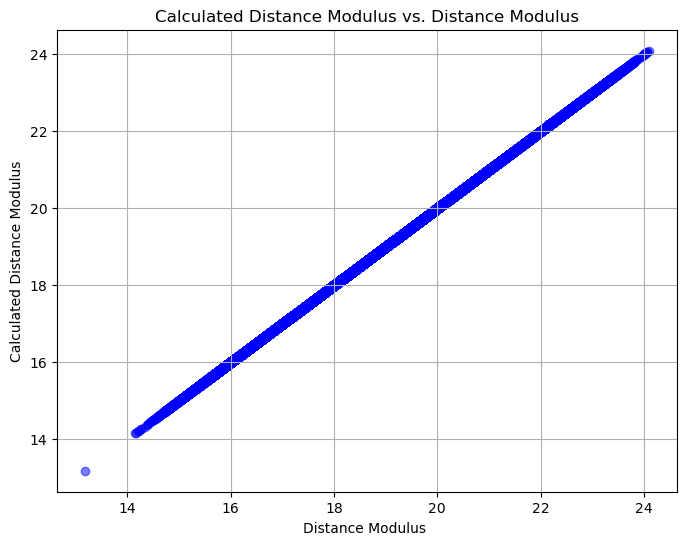

In [35]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
#plt.scatter(dmod, calculated_dmod, alpha=0.5, color='blue')
plt.scatter(dmod[downsampled_indices], calculated_dmod[downsampled_indices], alpha=0.5, color='blue')

# Set labels and title
plt.xlabel('Distance Modulus ')
plt.ylabel('Calculated Distance Modulus')
plt.title('Calculated Distance Modulus vs. Distance Modulus')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

## Distance

In [48]:
# If our color mag plot doesn't work, add a distance limit, only store the sources left to the peak. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


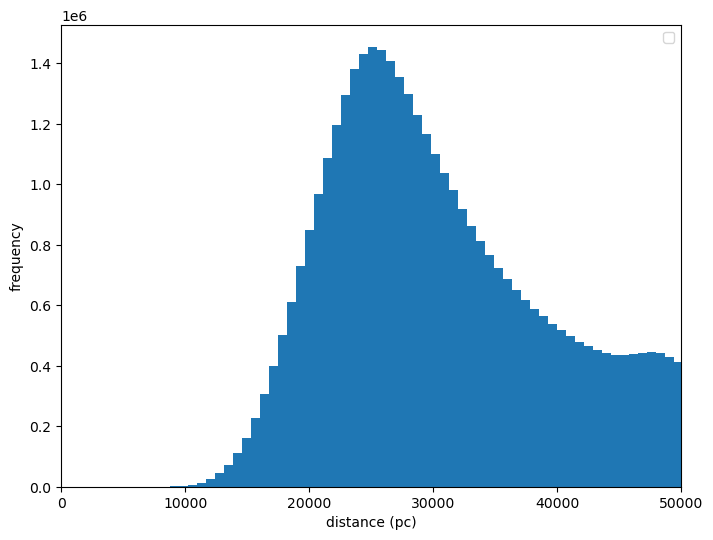

In [69]:
# Create a histogram of distances
plt.figure(figsize=(8, 6))
plt.hist(distance, bins=1000)

plt.xlabel("distance (pc)")
plt.xlim(0, 50000)

# Show the plot
plt.show()

### Distance Mask

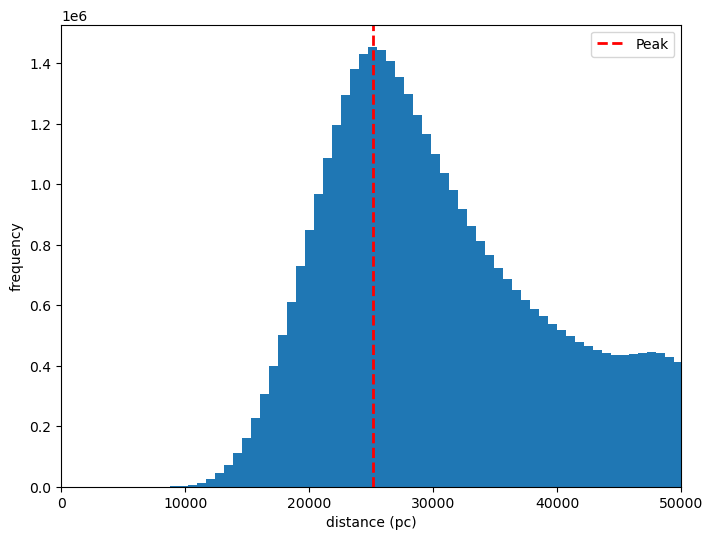

Peak center: 25117.597500053373 pc


In [67]:
from scipy.signal import find_peaks

# Create a histogram of distances and highlight the peak
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(distance, bins=1000)  # Use underscores to capture additional outputs

plt.xlabel("distance (pc)")
plt.ylabel("frequency")
plt.xlim(0, 50000)

# Find peaks in the histogram using scipy.signal.find_peaks
peaks, _ = find_peaks(hist)

# Find the index of the highest peak
peak_bin_index = peaks[np.argmax(hist[peaks])]
#peak_bin_index = np.argmax(hist) # Alternative without scipy.signal.find_peaks

# Calculate the bin center corresponding to the peak
peak_bin_center = (edges[peak_bin_index] + edges[peak_bin_index + 1]) / 2

# Highlight the peak on the histogram
plt.axvline(peak_bin_center, color='red', linestyle='dashed', linewidth=2, label='Peak')

# Show the plot
plt.legend()
plt.show()

# Print the center value
print(f"Peak center: {peak_bin_center} pc")

In [44]:
# Create a mask for distance
distance_mask = (distance >= peak_bin_center)

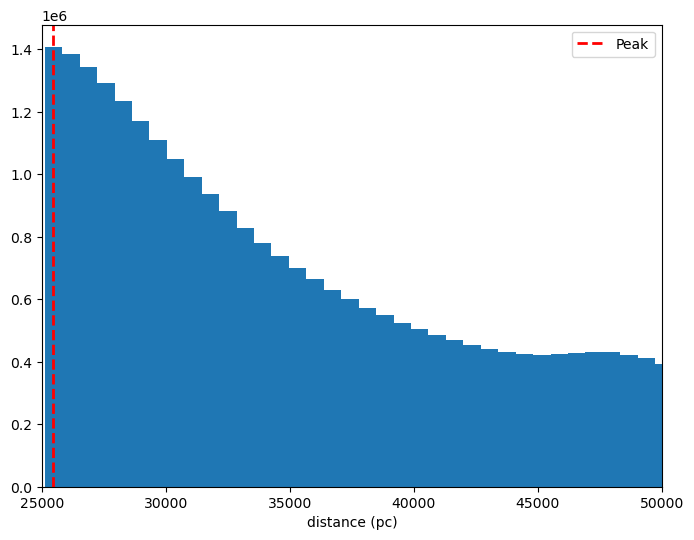

In [47]:
# Create a histogram of distances with distance mask
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(distance[distance_mask], bins=1000)  # Use underscores to capture additional outputs

plt.xlabel("distance (pc)")
plt.ylabel("frequency")
rounded_peak = round(peak_bin_center / 1000) * 1000 # Round the peak to the nearest 1000 for the lower limit
plt.xlim(rounded_peak, 50000)

# Find the bin with the highest frequency
peak_bin_index = np.argmax(hist)

# Calculate the bin center corresponding to the peak
peak_bin_center = (edges[peak_bin_index] + edges[peak_bin_index + 1]) / 2

# Highlight the peak on the histogram
plt.axvline(peak_bin_center, color='red', linestyle='dashed', linewidth=2, label='Peak')

# Show the plot
plt.legend()
plt.show()

## Galactic Latitude

In [60]:
# Filter out -15 to 15 glat. 
# After, try removing only the peaks. 
# Finally, create a Mag color diagram but only for the galaxies. Do not use any other filters that we added. 
# Make sure all the samples / filters are parameters

In [56]:
# Extract galactic latitude 
glat = survey.glat.to_numpy()

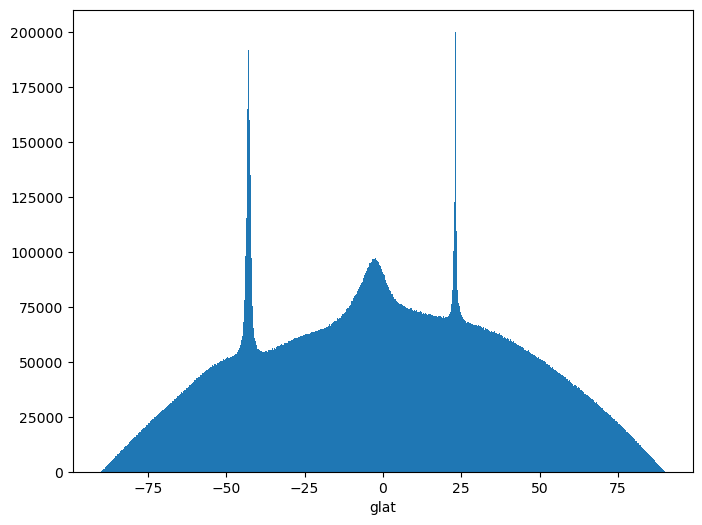

In [57]:
# Histogram of glat
plt.figure(figsize=(8, 6))
plt.hist(glat, bins=1000)

plt.xlabel("glat")
plt.ylabel("frequency")

# Show the plot
plt.show()

### Glat Plane Mask

In [80]:
# Create a mask to filter out anything not between -15 to 15 glat
fifteen_mask = (glat >= -15) & (glat <= 15)

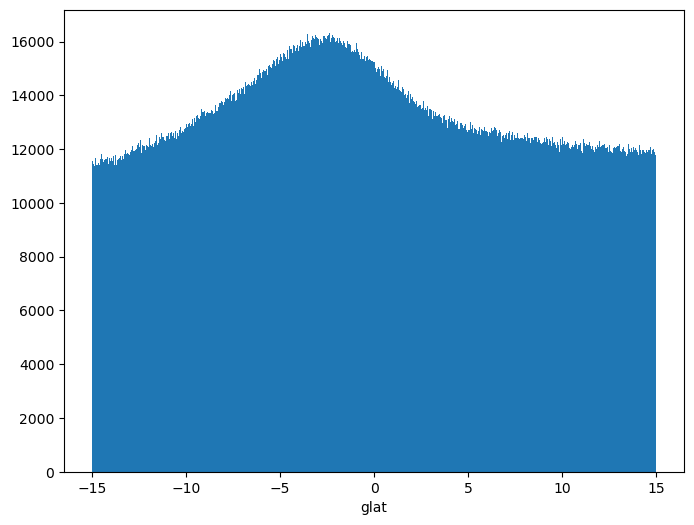

In [81]:
# Histogram of glat
glat = survey.glat.to_numpy()

plt.figure(figsize=(8, 6))
plt.hist(glat[fifteen_mask], bins=1000)

plt.xlabel("glat")

# Show the plot
plt.show()

### Glat Peak Mask

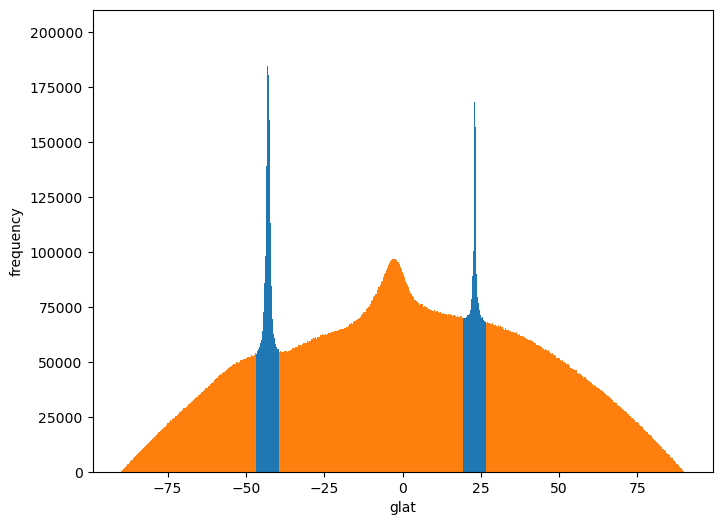

In [72]:
# Histogram of glat
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(glat, bins=1000)

plt.xlabel("glat")
plt.ylabel("frequency")

# Find peaks in the histogram
peaks, _ = find_peaks(hist)

# Sort peaks based on their heights
sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)

# Extend the range of indices to indclude lower and higher values
exclude_range = 20
exclude_indices = []
for index in top_two_peaks_indices:
    exclude_indices.extend(range(max(0, index - exclude_range), min(len(edges), index + exclude_range + 1)))

# Create a mask to remove the values corresponding to the peaks
glat_peak_mask = ~np.isin(np.digitize(glat, edges), exclude_indices)

# Plot the histogram without the values of the peaks
plt.hist(glat[glat_peak_mask], bins=1000)

# Show the plot
plt.show()

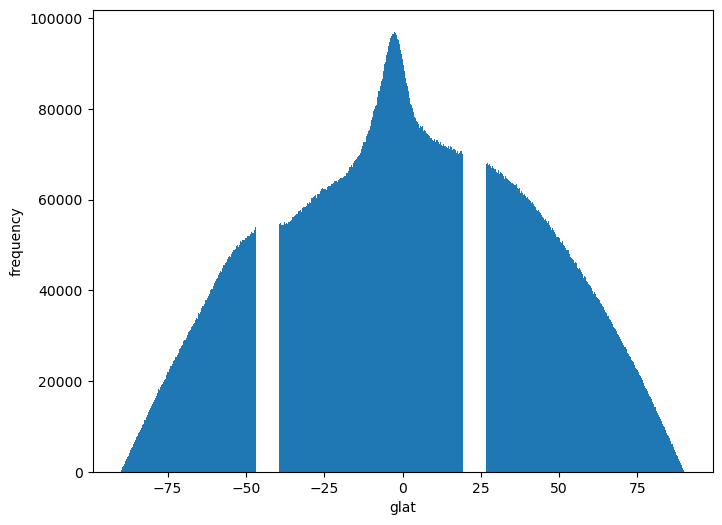

In [73]:
# Histogram of glat with mask applied
plt.figure(figsize=(8, 6))
plt.hist(glat[glat_peak_mask], bins=1000)

plt.xlabel("glat")
plt.ylabel("frequency")

# Show the plot
plt.show()

## Apparent Magnitude

In [74]:
# Extract g and r band
g_mag = survey.lsst_gmag.to_numpy()
r_mag = survey.lsst_rmag.to_numpy()

### Gmag Mask

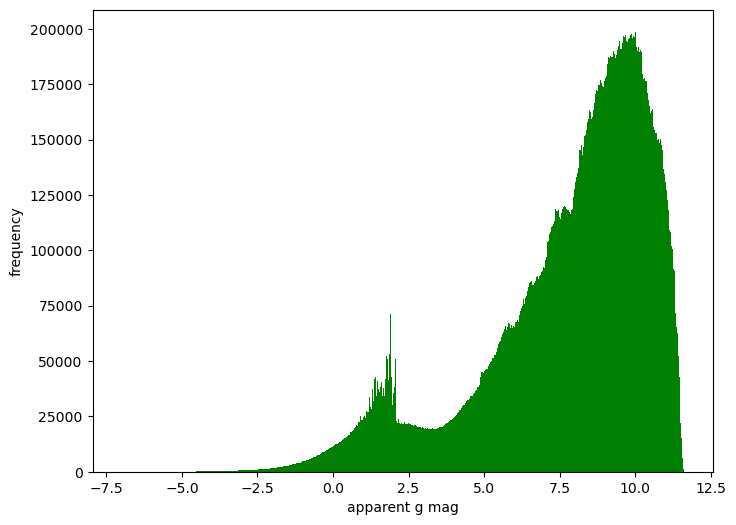

In [88]:
# Histogram of app g mag 
plt.figure(figsize=(8, 6))
plt.hist(g_mag, bins=1000, color='green')

plt.xlabel("apparent g mag")
plt.ylabel("frequency")

# Show the plot
plt.show()

In [89]:
# Try filter less than 10, more than 2.5. 

In [92]:
# Create a mask to filter out anything not between 2.5 to 10 gmag
g_mag_mask = (g_mag <= 10) & (g_mag >= 2.5)

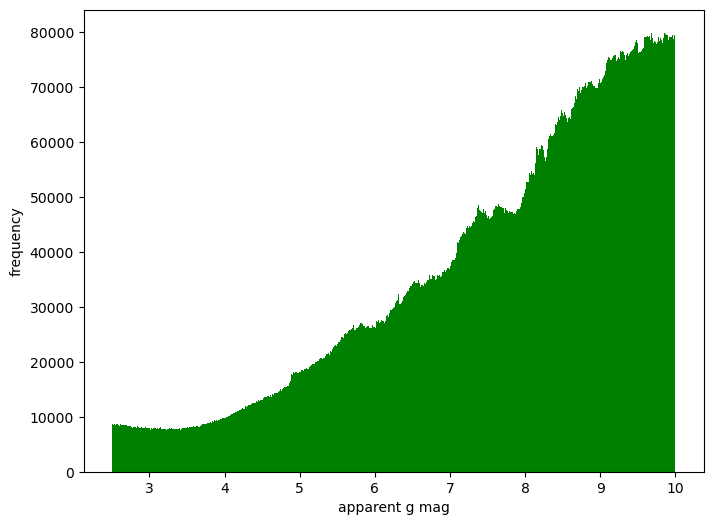

In [93]:
# Histogram of app g mag 
plt.figure(figsize=(8, 6))
plt.hist(g_mag[g_mag_mask], bins=1000, color='green')

plt.xlabel("apparent g mag")
plt.ylabel("frequency")

# Show the plot
plt.show()

### Rmag Mask

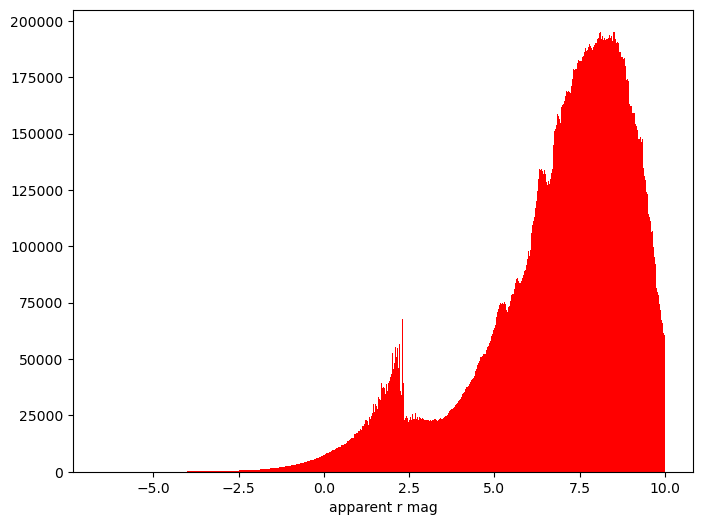

In [87]:
# Histogram of app r mag 
plt.figure(figsize=(8, 6))
plt.hist(r_mag, bins=1000, color='red')

plt.xlabel("apparent r mag")
plt.ylabel("frequency")

# Show the plot
plt.show()

In [94]:
# Create a mask to filter out anything not between 2.5 to 10 gmag
r_mag_mask = (r_mag <= 10) & (r_mag >= 2.5)

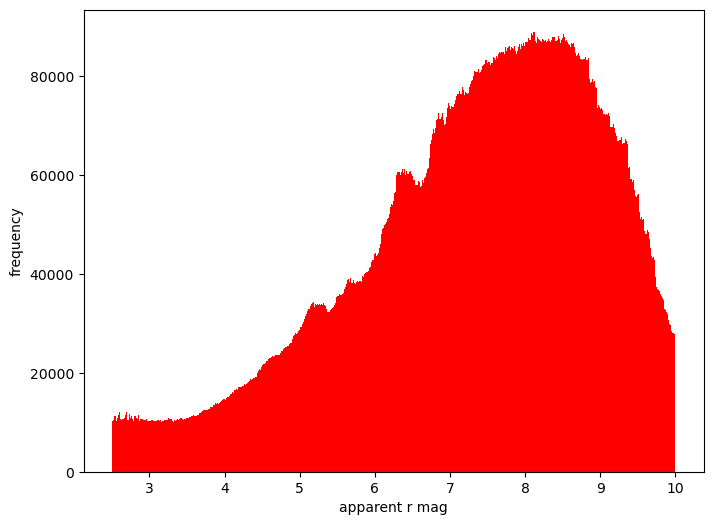

In [95]:
# Histogram of app r mag 
plt.figure(figsize=(8, 6))
plt.hist(r_mag[r_mag_mask], bins=1000, color='red')

plt.xlabel("apparent r mag")
plt.ylabel("frequency")

# Show the plot
plt.show()

### Compare gmag and rmag

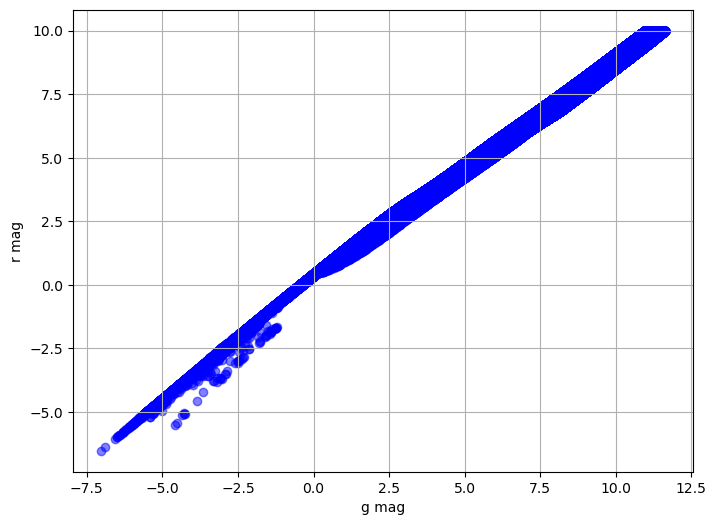

In [85]:
# Compare g mag and r mag
plt.figure(figsize=(8, 6))
plt.scatter(g_mag, r_mag, alpha=0.5, color='blue')

# Set labels and title
plt.xlabel('g mag')
plt.ylabel('r mag')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

## Create $g-r$ vs $M_g$ Diagram

In [99]:
# Calculate g - r
g_minus_r = g_mag - r_mag

### Plot using dmod from ananke output

This will use the distance modulus outputed from `ananke` when calculating the absolute magnitude $M_g$

In [100]:
# Calculate M_g with dmod
abs_mag_g = g_mag - dmod

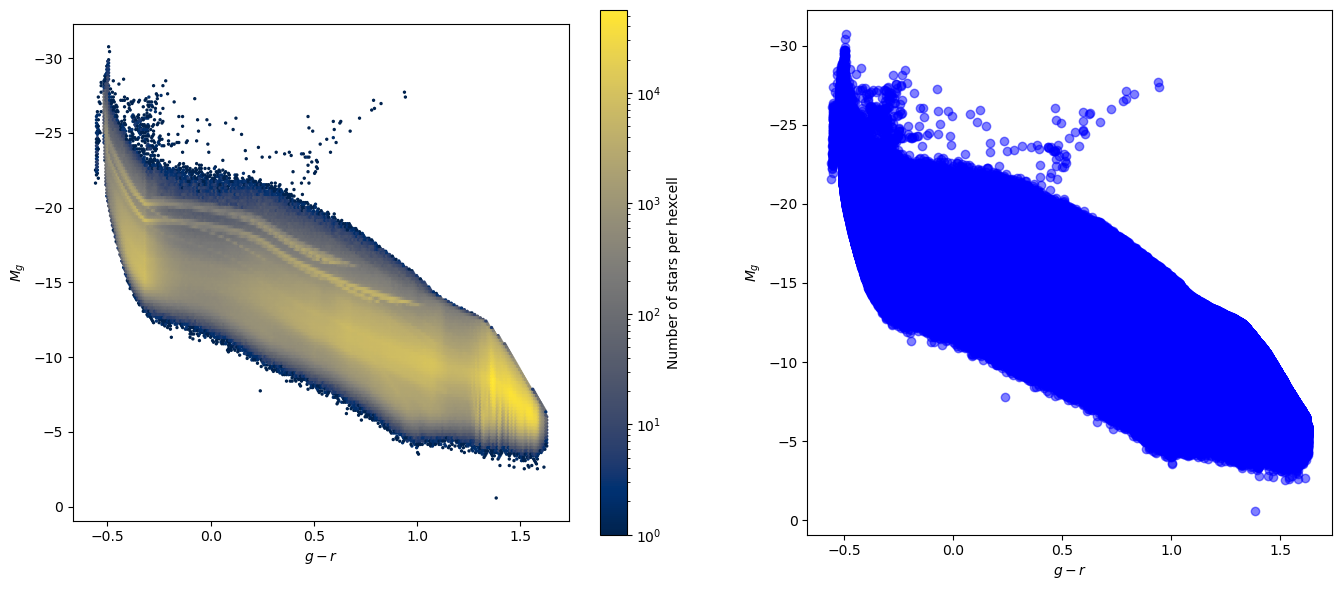

In [96]:
# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs[0].hexbin(g_minus_r, abs_mag_g, gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs[0].set_xlabel('$g - r$')
axs[0].set_ylabel('$M_g$')
axs[0].set_aspect(1.0/axs[0].get_data_ratio()) # Set aspect ratio
axs[0].invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs[0])
cbar.set_label('Number of stars per hexcell')

# Scatter plot for comparison
axs[1].scatter(g_minus_r, abs_mag_g, alpha=0.5, color='blue')
axs[1].set_xlabel('$g - r$')
axs[1].set_ylabel('$M_g$')
axs[1].set_aspect(1.0/axs[1].get_data_ratio()) # Set aspect ratio
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Plot using distance from ananke output

This will use the distance outputed from `ananke` when calculating the absolute magnitude $M_g$

In [102]:
# Calculate M_g with distance (check formula)
abs_mag_g_2 = g_mag - 5 * np.log10(distance) + 5

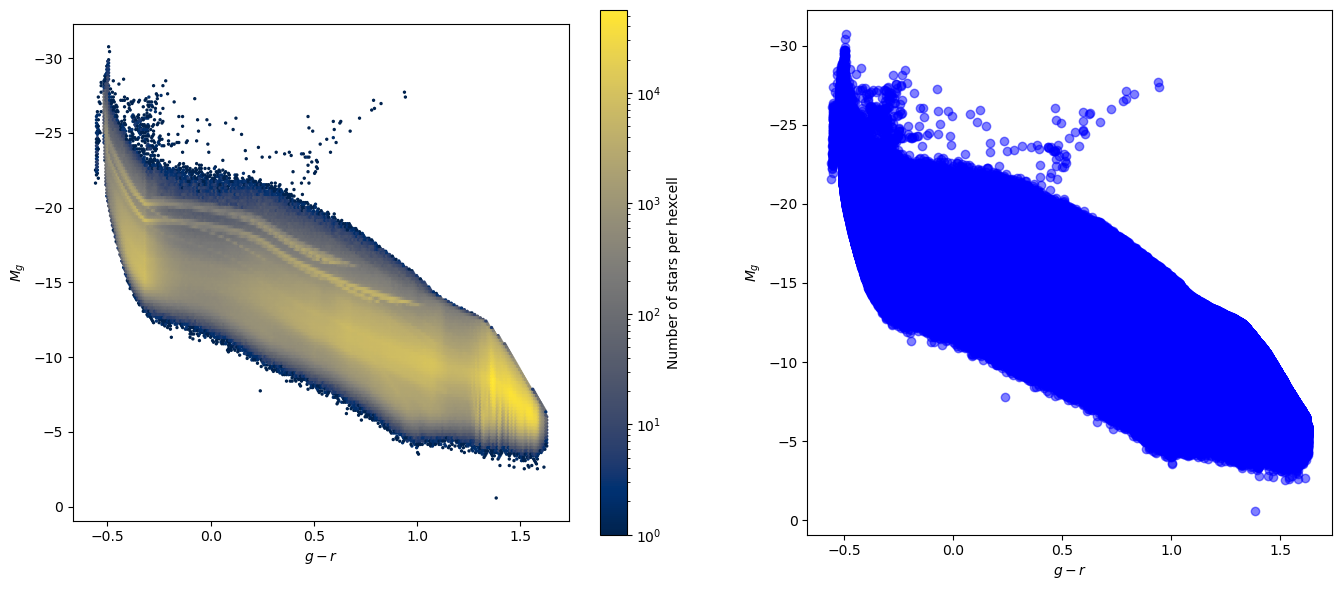

In [97]:
# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs[0].hexbin(g_minus_r, abs_mag_g_2, gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs[0].set_xlabel('$g - r$')
axs[0].set_ylabel('$M_g$')
axs[0].set_aspect(1.0/axs[0].get_data_ratio()) # Set aspect ratio
axs[0].invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs[0])
cbar.set_label('Number of stars per hexcell')

# Scatter plot for comparison
axs[1].scatter(g_minus_r, abs_mag_g_2, alpha=0.5, color='blue')
axs[1].set_xlabel('$g - r$')
axs[1].set_ylabel('$M_g$')
axs[1].set_aspect(1.0/axs[1].get_data_ratio()) # Set aspect ratio
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [98]:
# Histogram of each band (g, r, i, u, y, z)

## Color Magnitude Diagram with Filters